In [1]:
# Libraries
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt

# Local helper functions and classes
from helpers.dataset import IconsDataset, basic_img_transform as img_transform
from helpers.visualization import visualize_images
from helpers.gan import LambdaLayer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
bs = BATCH_SIZE
num_epochs = 500

In [ ]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [199]:
root_dir = 'icons/png32/images/'
dataset = IconsDataset(root_dir, transform=img_transform, imread_mode=cv2.IMREAD_GRAYSCALE)
loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

In [9]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real = x.view(-1, 1, 32, 32)
    y_real = torch.ones(x_real.shape[0], 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, 100, 1, 1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, 100, 1, 1).to(device))
    y = Variable(torch.ones(bs, 1).to(device))
    
    
    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [5]:
def generate_images(num_images):
    z = Variable(torch.randn(bs, 100, 1, 1).to(device))
    images = G(z)
    images = images.reshape(-1, 32, 32)
    return images

In [11]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

In [3]:
class Generator(nn.Module):
    def __init__(self, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.main(x)
        return output


class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

In [4]:
G = Generator().to(device)
D = Discriminator().to(device)

In [236]:
summary(g, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 32, 32]              64
             Tanh-14            [-1, 1,

In [237]:
summary(d, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,024
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
            Conv2d-6            [-1, 256, 4, 4]         524,288
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
            Conv2d-9            [-1, 512, 2, 2]       2,097,152
      BatchNorm2d-10            [-1, 512, 2, 2]           1,024
        LeakyReLU-11            [-1, 512, 2, 2]               0
           Conv2d-12              [-1, 1, 1, 1]           2,048
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,757,376
Trainable param

In [240]:
criterion = nn.BCELoss()   
lr = 0.0002
D_optimizer = optim.Adam(D.parameters(), lr=lr*4, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=lr/2, betas=(0.5, 0.999))












  0%|          | 0/500 [00:00<?, ?it/s]

[0/500]: loss_d: 0.743400, loss_g: 3.327116


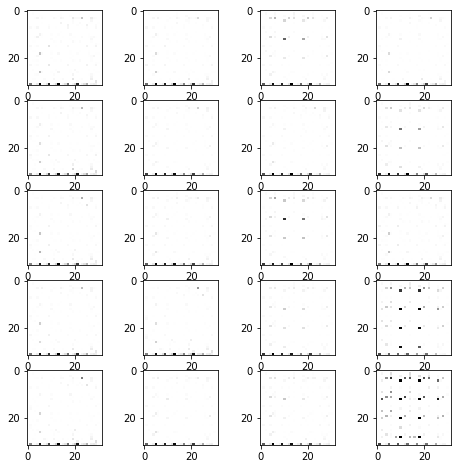












  0%|          | 1/500 [03:07<26:00:50, 187.68s/it]

[1/500]: loss_d: 0.534428, loss_g: 3.869230


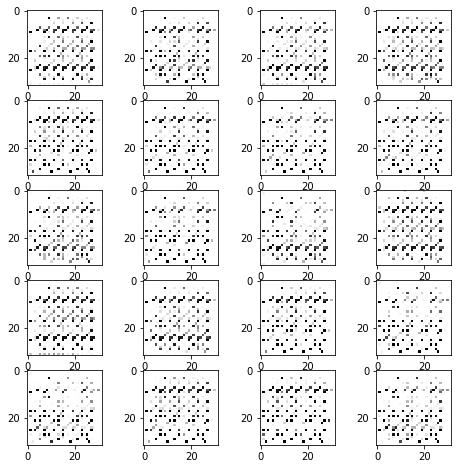












  0%|          | 2/500 [06:16<26:00:21, 188.00s/it]

[2/500]: loss_d: 0.828980, loss_g: 3.099529


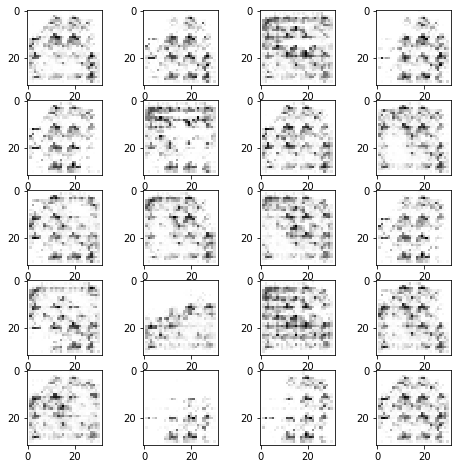












  1%|          | 3/500 [09:24<25:57:01, 187.97s/it]

[3/500]: loss_d: 0.965684, loss_g: 2.541160


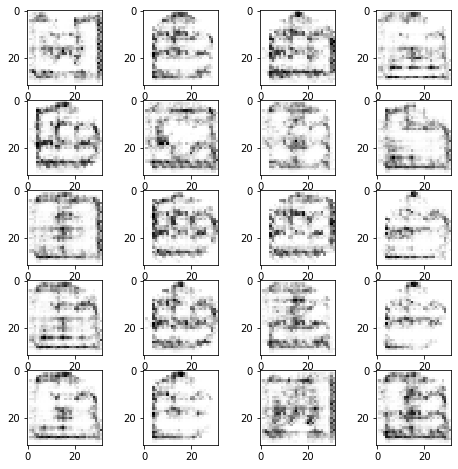












  1%|          | 4/500 [12:33<25:56:14, 188.25s/it]

[4/500]: loss_d: 1.042107, loss_g: 2.229112


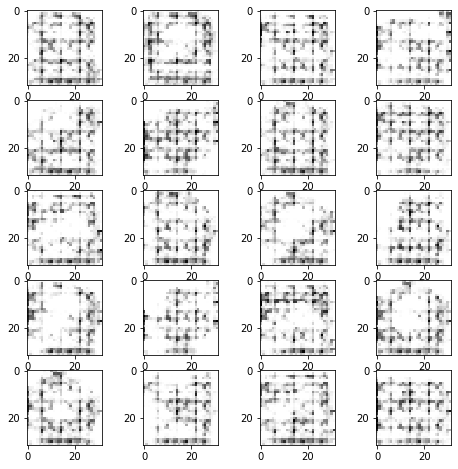












  1%|          | 5/500 [15:41<25:54:02, 188.37s/it]

[5/500]: loss_d: 1.088872, loss_g: 2.046198


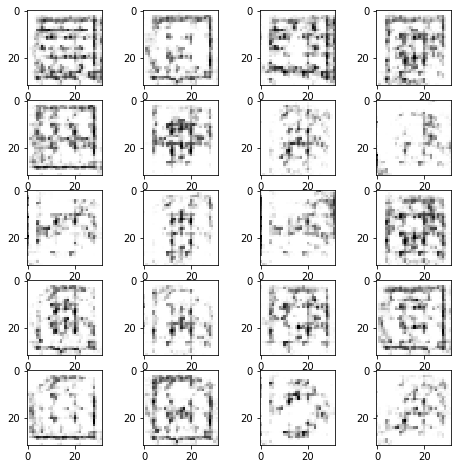












  1%|          | 6/500 [18:54<26:00:49, 189.57s/it]

[6/500]: loss_d: 1.112824, loss_g: 1.949374


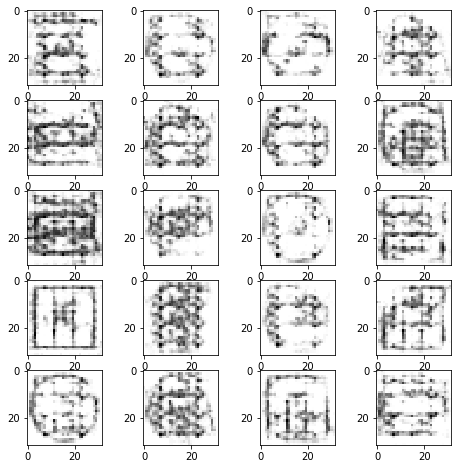












  1%|▏         | 7/500 [22:09<26:12:30, 191.38s/it]

[7/500]: loss_d: 1.121333, loss_g: 1.904406


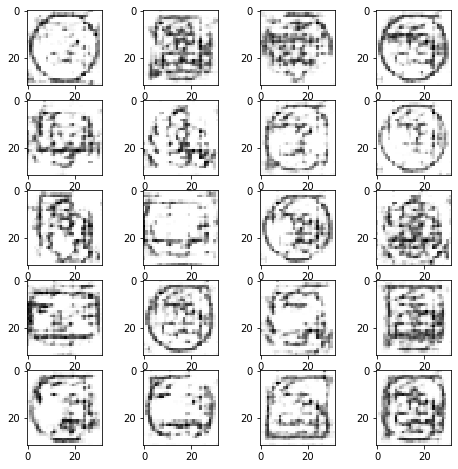












  2%|▏         | 8/500 [25:39<26:54:43, 196.92s/it]

[8/500]: loss_d: 1.113520, loss_g: 1.905978


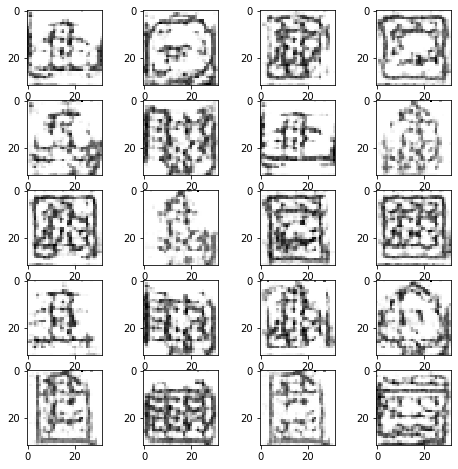












  2%|▏         | 9/500 [29:03<27:07:44, 198.91s/it]

[9/500]: loss_d: 1.094153, loss_g: 1.942613


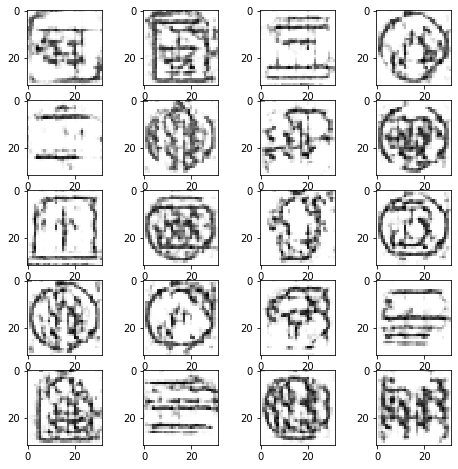












  2%|▏         | 10/500 [32:26<27:15:15, 200.24s/it]

[10/500]: loss_d: 1.063854, loss_g: 1.998892


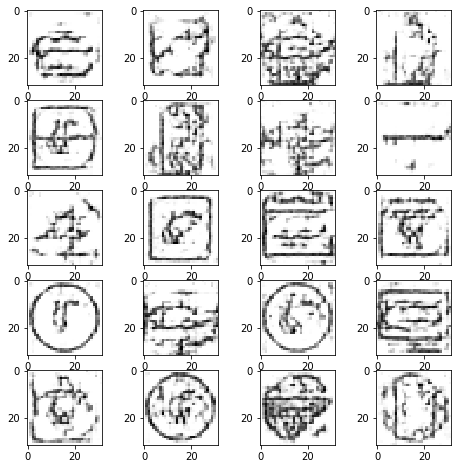












  2%|▏         | 11/500 [35:45<27:09:32, 199.94s/it]

[11/500]: loss_d: 1.026212, loss_g: 2.086639


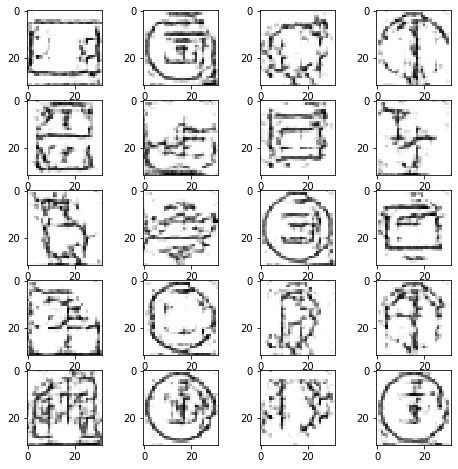












  2%|▏         | 12/500 [39:17<27:34:03, 203.37s/it]

[12/500]: loss_d: 0.993830, loss_g: 2.189977


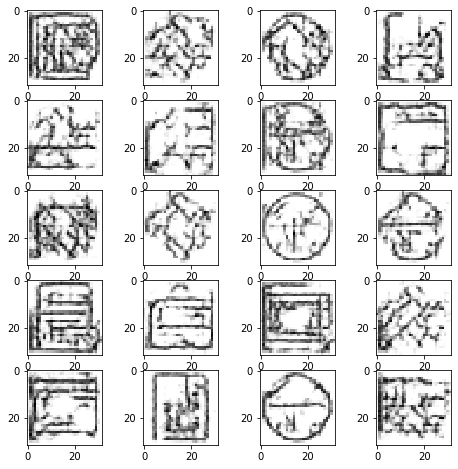












  3%|▎         | 13/500 [42:29<27:04:03, 200.09s/it]

[13/500]: loss_d: 0.949544, loss_g: 2.288836


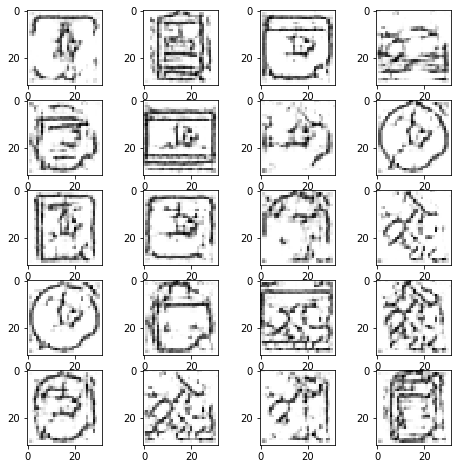












  3%|▎         | 14/500 [45:46<26:52:55, 199.13s/it]

[14/500]: loss_d: 0.912565, loss_g: 2.420943


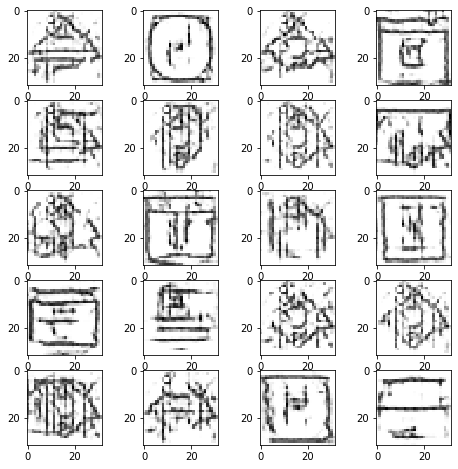












  3%|▎         | 15/500 [49:13<27:08:20, 201.45s/it]

[15/500]: loss_d: 0.883088, loss_g: 2.533290


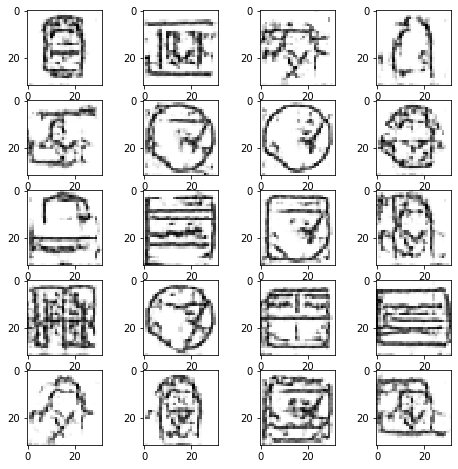












  3%|▎         | 16/500 [52:37<27:11:53, 202.30s/it]

[16/500]: loss_d: 0.848284, loss_g: 2.631295


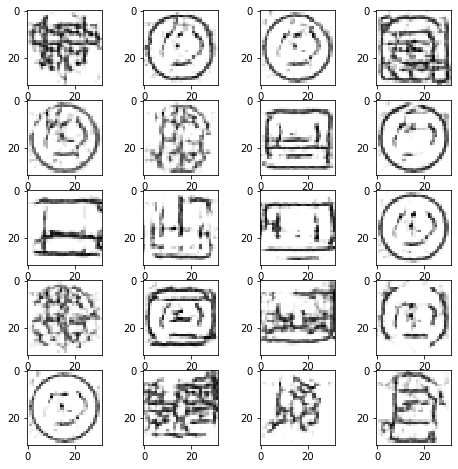












  3%|▎         | 17/500 [56:00<27:08:35, 202.31s/it]

[17/500]: loss_d: 0.817725, loss_g: 2.738302


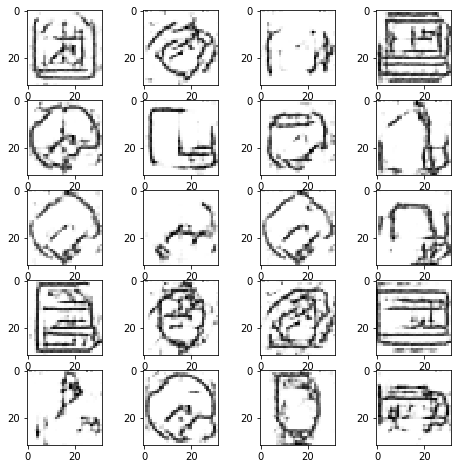












  4%|▎         | 18/500 [59:16<26:51:50, 200.64s/it]

[18/500]: loss_d: 0.796433, loss_g: 2.828859


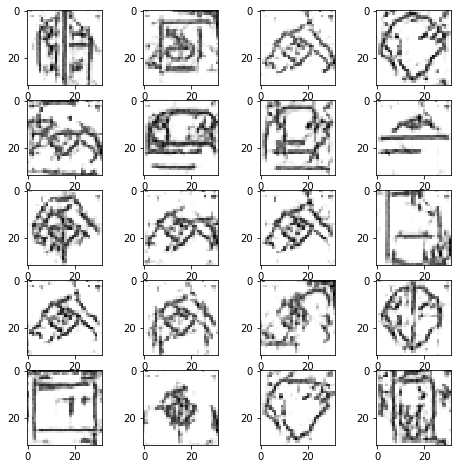












  4%|▍         | 19/500 [1:02:47<27:11:54, 203.56s/it]

[19/500]: loss_d: 0.769808, loss_g: 2.925308


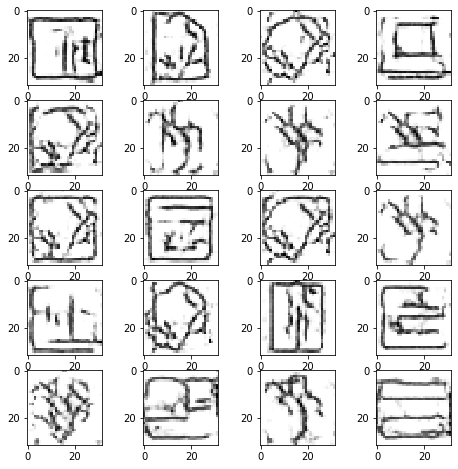












  4%|▍         | 20/500 [1:05:59<26:41:12, 200.15s/it]

KeyboardInterrupt: 

In [242]:
D_losses, G_losses = [], []
z_dim = 100

for epoch in tqdm(range(num_epochs)):
    for batch_idx, x in enumerate(loader):
        for i in range(4):
            G_losses.append(G_train(x))
        D_losses.append(D_train(x))
    print('[%d/%d]: loss_d: %.6f, loss_g: %.6f' % (
        (epoch), num_epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    images = generate_images(21)
    visualize_images(images, function=lambda x: x.cpu().detach().numpy(), cmap='gray')
    torch.save(D.state_dict(), 'discriminator_DCGAN')
    torch.save(G.state_dict(), 'generator_DCGAN')

plt.plot(np.log(D_losses))
plt.show()
plt.plot(np.log(G_losses))
plt.show()



In [2]:
!mkdir generated
!mkdir ./generated/DCGAN

mkdir: cannot create directory ‘generated’: File exists


In [6]:
test_generator_dict = torch.load('generator_DCGAN')
G.load_state_dict(test_generator_dict)

<All keys matched successfully>

In [7]:
images = generate_images(21)

In [9]:
import scipy.misc
import os

path = 'generated/DCGAN/'
i = 0 
for image in images:
    image = image.cpu().detach().numpy()
    pth = os.path.join(path, '{}.png'.format(i))
    plt.imsave(pth, image, cmap='gray')
    i += 1